In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Evaluation

In [13]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model_from_file(ground_truth_file, prediction_file):
    """
    Evaluate model prediction given CSV files for ground truth and predicted values.
    
    Parameters:
    - ground_truth_file: path to CSV with columns ['y_valence', 'y_arousal']
    - prediction_file: path to CSV with columns ['pred_valence', 'pred_arousal']
    
    Returns:
    - dict of evaluation metrics
    """

    # Load data
    df_true = pd.read_csv(ground_truth_file)
    df_pred = pd.read_csv(prediction_file)

    # Extract values
    true_valence = df_true['y_valence'].values
    true_arousal = df_true['y_arousal'].values
    pred_valence = df_pred['pred_valence'].values
    pred_arousal = df_pred['pred_arousal'].values

    # RMSE
    rmse_val = mean_squared_error(true_valence, pred_valence, squared=False)
    rmse_aro = mean_squared_error(true_arousal, pred_arousal, squared=False)

    # Normalized RMSE
    range_val = max(true_valence) - min(true_valence)
    range_aro = max(true_arousal) - min(true_arousal)
    nrmse_val = rmse_val / range_val if range_val > 0 else None
    nrmse_aro = rmse_aro / range_aro if range_aro > 0 else None

    # R²
    r2_val = r2_score(true_valence, pred_valence)
    r2_aro = r2_score(true_arousal, pred_arousal)

    # Print results
    print(f"\n📊 Evaluation Results:")
    print(f"RMSE for Valence: {rmse_val:.4f}")
    print(f"RMSE for Arousal: {rmse_aro:.4f}")
    print(f"Normalized RMSE for Valence: {nrmse_val:.4f}" if nrmse_val is not None else "Valence range is zero.")
    print(f"Normalized RMSE for Arousal: {nrmse_aro:.4f}" if nrmse_aro is not None else "Arousal range is zero.")
    print(f"R² for Valence: {r2_val:.4f}")
    print(f"R² for Arousal: {r2_aro:.4f}")

    return {
        'rmse_valence': rmse_val,
        'rmse_arousal': rmse_aro,
        'normalized_rmse_valence': nrmse_val,
        'normalized_rmse_arousal': nrmse_aro,
        'r2_valence': r2_val,
        'r2_arousal': r2_aro
    }


In [6]:
# === Step 1: 读取三个输入文件 ===
# 真值包含 y_valence 和 y_arousal 列
df_truth = pd.read_csv("data/merged/merged_cleaned_sentiment_validation.csv")
df_audio = pd.read_csv("csv/AUdio_predictions_mlp_torch.csv")
df_lyrics = pd.read_csv("csv/lyrics/Lyrics_predictions_mlp_torch.csv")

# 提取真值和预测结果（均为 shape: [n_samples, 2]）
y_true = df_truth[["y_valence", "y_arousal"]].values
pred_audio = df_audio.values
pred_lyrics = df_lyrics.values

In [7]:


# === Step 2: 进行 alpha grid search ===
alphas = np.linspace(0, 1, 21)  # 从 0.0 到 1.0，每隔 0.05
results = []

for alpha in alphas:
    fused = alpha * pred_audio + (1 - alpha) * pred_lyrics
    rmse_val = mean_squared_error(y_true[:, 0], fused[:, 0], squared=False)
    rmse_aro = mean_squared_error(y_true[:, 1], fused[:, 1], squared=False)
    avg_rmse = (rmse_val + rmse_aro) / 2
    results.append((alpha, rmse_val, rmse_aro, avg_rmse))

# 转成 DataFrame 方便查看
df_results = pd.DataFrame(results, columns=["alpha", "rmse_valence", "rmse_arousal", "avg_rmse"])

# 打印最优 alpha
best_row = df_results.loc[df_results["avg_rmse"].idxmin()]
best_alpha = best_row["alpha"]
print(f"\n✅ 最优 alpha = {best_alpha:.2f}, 平均 RMSE = {best_row['avg_rmse']:.4f}")




✅ 最优 alpha = 0.80, 平均 RMSE = 0.8920


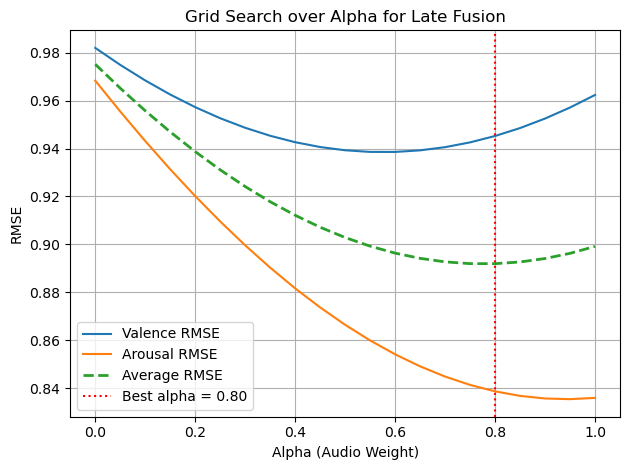

In [8]:
# === Step 3: 可视化 RMSE vs alpha ===
plt.plot(df_results["alpha"], df_results["rmse_valence"], label="Valence RMSE")
plt.plot(df_results["alpha"], df_results["rmse_arousal"], label="Arousal RMSE")
plt.plot(df_results["alpha"], df_results["avg_rmse"], label="Average RMSE", linestyle="--", linewidth=2)
plt.axvline(best_alpha, color="red", linestyle=":", label=f"Best alpha = {best_alpha:.2f}")
plt.xlabel("Alpha (Audio Weight)")
plt.ylabel("RMSE")
plt.title("Grid Search over Alpha for Late Fusion")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
# === Step 4: 保存最优融合结果（可选）===
fused_best = best_alpha * pred_audio + (1 - best_alpha) * pred_lyrics
df_fused = pd.DataFrame(fused_best, columns=["pred_valence", "pred_arousal"])
df_fused.to_csv("latefushion/fused_alpha_best.csv", index=False)
print("✅ 已保存最优融合结果到 fused_alpha_best.csv")

✅ 已保存最优融合结果到 fused_alpha_best.csv


# Per_target

In [10]:

alphas = np.linspace(0, 1, 21)
best_alpha_val, best_rmse_val = None, float("inf")
best_alpha_aro, best_rmse_aro = None, float("inf")
rmse_vals, rmse_aros = [], []

for alpha in alphas:
    pred_val = alpha * pred_audio[:, 0] + (1 - alpha) * pred_lyrics[:, 0]
    rmse_val = mean_squared_error(y_true[:, 0], pred_val, squared=False)
    rmse_vals.append(rmse_val)
    if rmse_val < best_rmse_val:
        best_rmse_val = rmse_val
        best_alpha_val = alpha

    pred_aro = alpha * pred_audio[:, 1] + (1 - alpha) * pred_lyrics[:, 1]
    rmse_aro = mean_squared_error(y_true[:, 1], pred_aro, squared=False)
    rmse_aros.append(rmse_aro)
    if rmse_aro < best_rmse_aro:
        best_rmse_aro = rmse_aro
        best_alpha_aro = alpha

# 最终融合
fused_valence = best_alpha_val * pred_audio[:, 0] + (1 - best_alpha_val) * pred_lyrics[:, 0]
fused_arousal = best_alpha_aro * pred_audio[:, 1] + (1 - best_alpha_aro) * pred_lyrics[:, 1]
df_fused = pd.DataFrame(np.column_stack([fused_valence, fused_arousal]), columns=["pred_valence", "pred_arousal"])
print(f"\n🎯 最优融合参数（per-target）:")
print(f"  ✅ Valence  : alpha = {best_alpha_val:.2f} | RMSE = {best_rmse_val:.4f}")
print(f"  ✅ Arousal  : alpha = {best_alpha_aro:.2f} | RMSE = {best_rmse_aro:.4f}")





🎯 最优融合参数（per-target）:
  ✅ Valence  : alpha = 0.60 | RMSE = 0.9386
  ✅ Arousal  : alpha = 0.95 | RMSE = 0.8355


In [11]:
df_fused.to_csv("latefushion/fused_dual_alpha_best.csv", index=False)
print("✅ 最优 per-target 融合结果已保存为 fused_dual_alpha_best.csv")


✅ 最优 per-target 融合结果已保存为 fused_dual_alpha_best.csv


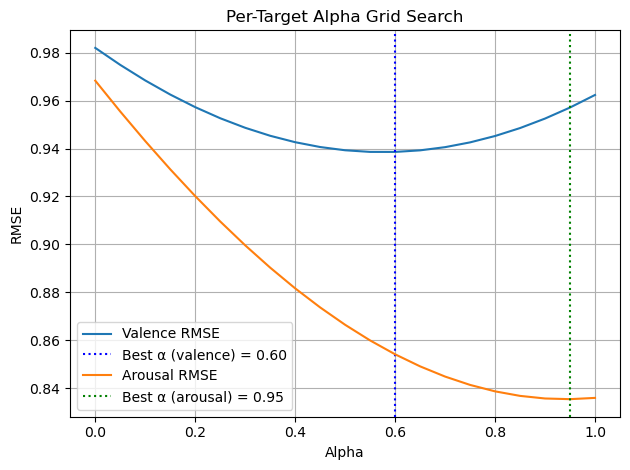

In [12]:
# 画图
plt.plot(alphas, rmse_vals, label="Valence RMSE")
plt.axvline(best_alpha_val, color="blue", linestyle=":", label=f"Best α (valence) = {best_alpha_val:.2f}")
plt.plot(alphas, rmse_aros, label="Arousal RMSE")
plt.axvline(best_alpha_aro, color="green", linestyle=":", label=f"Best α (arousal) = {best_alpha_aro:.2f}")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.title("Per-Target Alpha Grid Search")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Compare

In [15]:
evaluate_model_from_file(
    ground_truth_file="data/merged/merged_cleaned_sentiment_validation.csv",
    prediction_file="lateFushion/fused_dual_alpha_best.csv"
)



📊 Evaluation Results:
RMSE for Valence: 0.9386
RMSE for Arousal: 0.8355
Normalized RMSE for Valence: 0.2696
Normalized RMSE for Arousal: 0.1642
R² for Valence: 0.1801
R² for Arousal: 0.2280


{'rmse_valence': 0.938585030442066,
 'rmse_arousal': 0.8354654458472273,
 'normalized_rmse_valence': 0.26955618986274,
 'normalized_rmse_arousal': 0.16418069009990385,
 'r2_valence': 0.18006826980075652,
 'r2_arousal': 0.22799068626400065}

📊 Evaluation Results:
RMSE for Valence: 0.9452
RMSE for Arousal: 0.8387
Normalized RMSE for Valence: 0.2715
Normalized RMSE for Arousal: 0.1648
R² for Valence: 0.1684
R² for Arousal: 0.2220

📊 Evaluation Results:
RMSE for Valence: 0.9386
RMSE for Arousal: 0.8355
Normalized RMSE for Valence: 0.2696
Normalized RMSE for Arousal: 0.1642
R² for Valence: 0.1801
R² for Arousal: 0.2280